In [1]:
import pandas as pd
from pybaseball import statcast
import warnings
import matplotlib.pyplot as plt
from matplotlib import patches
from datetime import datetime, timedelta
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif



lookup_start = (datetime.today()-timedelta(days=14)).strftime('%Y-%m-%d')
lookup_end = datetime.today().strftime('%Y-%m-%d')

warnings.filterwarnings(action='ignore', category=FutureWarning)
pitch_data = statcast(start_dt=lookup_start, end_dt=lookup_end, verbose=False)

#Describe data
pitch_data.describe()


100%|██████████| 15/15 [00:01<00:00,  8.26it/s]


,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
count,53698,53698.0,53698.0,53698.0,53698.0,53698.0,0.0,0.0,0.0,0.0,...,53698.0,53698.0,53698.0,53698.0,53698.0,53151.0,53698.0,53694.0,25352.0,25352.0
mean,2024-07-30 08:11:02.371037952,89.177366,-0.809722,5.732266,644742.586837,636876.401952,<NA>,<NA>,<NA>,<NA>,...,2.46417,2.59883,2.332806,2.467466,2.46417,177.495005,-0.000081,0.002616,69.512196,7.224561
min,2024-07-24 00:00:00,32.8,-4.73,0.97,444482.0,445276.0,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.741,-1.215,2.53242,0.55883
25%,2024-07-27 00:00:00,84.9,-2.15,5.45,623912.0,607259.0,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,129.0,0.0,-0.065,67.094022,6.6503
50%,2024-07-30 00:00:00,90.0,-1.53,5.77,664023.0,657097.0,<NA>,<NA>,<NA>,<NA>,...,2.0,2.0,2.0,2.0,2.0,201.0,0.0,-0.015,70.977325,7.28343
75%,2024-08-03 00:00:00,94.0,0.91,6.06,673237.0,671345.0,<NA>,<NA>,<NA>,<NA>,...,4.0,4.0,4.0,4.0,4.0,226.0,0.0,0.033,74.266035,7.894583
max,2024-08-06 00:00:00,104.7,4.6,8.06,807799.0,806185.0,<NA>,<NA>,<NA>,<NA>,...,20.0,14.0,20.0,20.0,20.0,360.0,0.858,3.492,87.9758,10.17014
std,NaN,6.033758,1.903872,0.5229,49751.476072,53669.706207,<NA>,<NA>,<NA>,<NA>,...,2.693358,2.625483,2.703771,2.642866,2.693358,73.969157,0.027382,0.245425,8.907276,0.986387


Text(0.5, 1.0, 'Average Velocities by Pitch Type \n(MLB, 2024-07-24 thru 2024-08-07)')

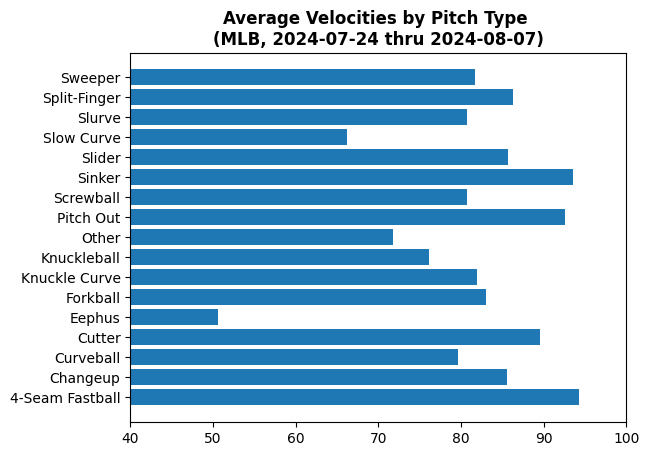

In [2]:
#Plot average pitch velocities
data1 = pitch_data[['pitch_name', 'release_speed']].groupby('pitch_name').release_speed.agg(['mean','count']).reset_index()

plt.barh(data1['pitch_name'], data1['mean'])
plt.xlim((40,100))
plt.title(f'Average Velocities by Pitch Type \n(MLB, {lookup_start} thru {lookup_end})', weight='bold')


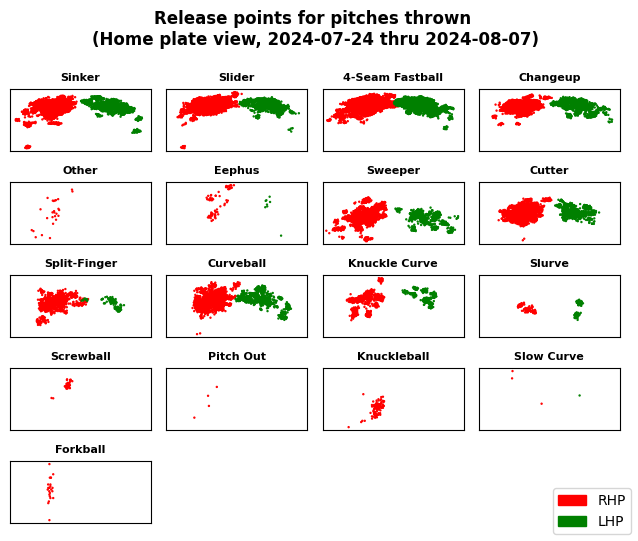

In [3]:
#Plot pitch release points for each pitch type, split colors into red (RHP) and green (LHP)
import math
from itertools import product

data2 = pitch_data[['p_throws','pitch_name', 'release_pos_x', 'release_pos_z']]
pitch_names = pitch_data['pitch_name'].drop_duplicates().dropna()

r_patch = patches.Patch(color='red', label='RHP')
l_patch = patches.Patch(color='green', label='LHP')

num_pitches = len(pitch_names)
num_rows = math.ceil(num_pitches/4.0)
subplots = num_rows*4

#Max of 16 subplots, aka, 16 pitch types
fig, axs = plt.subplots(num_rows,4, sharey='row')
for (num,pitch) in enumerate(pitch_names):
    temp = data2[data2['pitch_name'] == pitch]
    axs[num//4, num % 4].scatter(temp['release_pos_x'], temp['release_pos_z'], s=0.5, c=['red' if i=='R' else 'green' for i in temp['p_throws']])
    axs[num//4, num % 4].set_xlim([-5, 5])
    axs[num//4, num % 4].set_title(pitch, fontsize=8, fontweight='bold')
    axs[num//4, num % 4].get_xaxis().set_visible(False)
    axs[num//4, num % 4].get_yaxis().set_visible(False)

#Remove any unused subplots
unused_plots = subplots - num_pitches
plot_indices = [list(i) for i in list(product(list(range(num_rows))[::-1], list(range(4))[::-1]))]
if unused_plots > 0:
    for i in range(unused_plots):
        exec(f'fig.delaxes(axs{plot_indices[i]})') 
    

fig.tight_layout()
fig.suptitle(f'Release points for pitches thrown \n(Home plate view, {lookup_start} thru {lookup_end})', y=1.1, fontweight='bold')
fig.legend(handles=[r_patch, l_patch], loc='lower right')





In [4]:
from scipy.stats import chi2_contingency

X = pitch_data[['release_speed', 'release_pos_x', 'release_pos_z', 'p_throws', 'pfx_x', 'pfx_z', 'spin_axis', 'release_spin_rate', 'pitch_type']].dropna().copy()
y = X.pop('pitch_type')

#First look at p_throws compared to pitch_type
stat, p, dof, exp = chi2_contingency(pd.crosstab(X['p_throws'], y).values)

if p<0.05:
    print(f"P-value = {p}. Reject H0 (Likely relationship between pitching arm and expected pitch type)")
else:

    print(f"P-value = {p}. Fail to reject H0 (Likely no relation between pitching arm and expected pitch type)")




P-value = 7.242977144815433e-114. Reject H0 (Likely relationship between pitching arm and expected pitch type)


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'release_speed'),
  Text(1, 0, 'release_pos_x'),
  Text(2, 0, 'release_pos_z'),
  Text(3, 0, 'pfx_x'),
  Text(4, 0, 'pfx_z'),
  Text(5, 0, 'spin_axis'),
  Text(6, 0, 'release_spin_rate')])

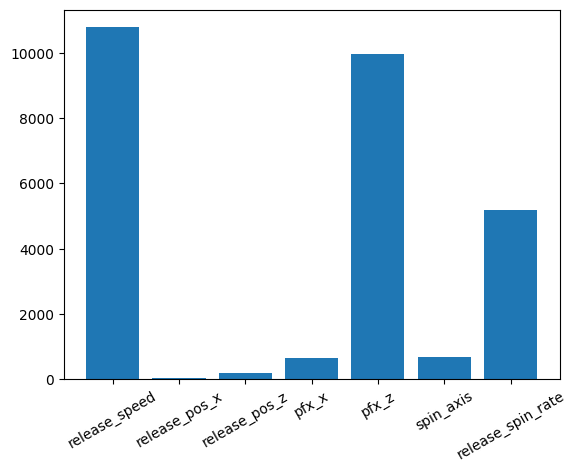

In [5]:
#Now observe numerical variables
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'spin_axis', 'release_spin_rate']], y)
X_fs = fs.transform(X[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'spin_axis', 'release_spin_rate']])

plt.bar(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'spin_axis', 'release_spin_rate'], fs.scores_)
plt.xticks(rotation=30)
